In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.nn import BatchNorm1d
import torch.nn.functional as F

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import StratifiedKFold
import torch  # For building the networks
import torchtuples as tt  # Some useful functions

from pycox.datasets import metabric
from pycox.models import MTLR
from pycox.evaluation import EvalSurv

from utils.utils import setup_seed, load_config
from utils.data import get_discrete_time


def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))


# class minimalMLP(nn.Module):
#     def __init__(self, config):
#         super().__init__()

#         self.layer_1 = nn.Sequential(
#             nn.Linear(config["input_dim"], config["trunk_ls"]), BatchNorm1d(config["trunk_ls"]), nn.ReLU()
#         )
#         self.layer_2 = nn.Sequential(
#             nn.Linear(config["trunk_ls"], config["surv_ds"]), BatchNorm1d(config["surv_ds"]), nn.ReLU()
#         )
#         self.layer_cls = nn.Linear(config["surv_ds"], config["n_buckets"])

#     def forward(self, x):
#         x = self.layer_1(x)

#         x = self.layer_2(x)

#         y = self.layer_cls(x)
#         return y

class minimalMLP(nn.Module):
    def __init__(self,n_buckets, input_dim=100, latent_dim=32):
        super().__init__()
        self.n_buckets = n_buckets  # number of time intervals in the survival model

        self.layer_1 = nn.Sequential(nn.Linear(input_dim, latent_dim), nn.ReLU())
        self.layer_2 = nn.Sequential(nn.Linear(latent_dim, latent_dim), nn.ReLU())
        self.layer_cls = nn.Linear(latent_dim, n_buckets)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        y = self.layer_cls(x)
        return y

config = load_config("config.json")
setup_seed(config["seed"])

In [3]:
gt_df = pd.read_csv(config["gt_path"])
gt_df.head()

,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID
0,A1-A0SF,0,LumA,False,1463,LumA_0
1,A1-A0SJ,0,LumA,False,416,LumA_0
2,A1-A0SK,2,Basal,True,967,Basal_1
3,A1-A0SO,2,Basal,False,852,Basal_0
4,A1-A0SQ,0,LumA,False,554,LumA_0


In [4]:
y = get_discrete_time(gt_df, config["n_buckets"])
y.shape

(503, 6)

In [5]:
latent_df = pd.read_csv(config["latent_path"])
data_x = latent_df.iloc[:, 1:].values
data_x.shape

(503, 100)

In [6]:
train_mask = get_bool_mask(gt_df, pd.read_csv(config["train_path"])["Sample_ID"])
train_y = gt_df["Strat_ID"][train_mask]
train_ids = gt_df["Sample_ID"][train_mask]

train_y.shape

(402,)

In [13]:
def get_data(gt_df, train_mask, test_mask):
    df_y_train = gt_df[train_mask]
    df_y_test = gt_df[test_mask]

    labtrans = MTLR.label_transform(config["n_buckets"])
    get_target = lambda df: (df["Survival_in_days"].values, df["Status"].values)
    y_train = labtrans.fit_transform(*get_target(df_y_train))

    # # We don't need to transform the test labels
    durations_test, events_test = get_target(df_y_test)

    x_train = data_x[train_mask].astype("float32")
    x_test = data_x[test_mask].astype("float32")

    return x_train, y_train, x_test, durations_test, events_test, labtrans


def train_model(config, x_train, y_train, labtrans):
    config["input_dim"] = x_train.shape[1]
    batch_size = x_train.shape[0]
    net = minimalMLP(config)

    model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)

    model.optimizer.set_lr(config["lr"])
    callbacks = [tt.callbacks.EarlyStopping()]
    log = model.fit(
        x_train, y_train, batch_size, config["epochs"], callbacks, verbose=False
    )
    # _ = log.plot()

    return model



skf = StratifiedKFold(
    n_splits=config["n_kfolds"], random_state=config["seed"], shuffle=True
)
metrics = []

for k, (train_index, val_index) in enumerate(skf.split(train_ids, train_y)):
    train_mask = get_bool_mask(gt_df, gt_df["Sample_ID"][train_index])
    val_mask = get_bool_mask(gt_df, gt_df["Sample_ID"][val_index])

    x_train, y_train, x_val, durations_val, events_val, labtrans = get_data(
        gt_df, train_mask, val_mask
    )

    model = train_model(config, x_train, y_train, labtrans)

    surv = model.interpolate(5).predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_val, events_val, censor_surv="km")

    metrics.append(ev.concordance_td("antolini"))
metrics = np.array(metrics)

In [14]:
metrics

array([0.44621514, 0.45432099, 0.43921569, 0.5       , 0.44256757])

In [15]:
train_mask = get_bool_mask(
    gt_df, pd.read_csv("./data/MoGCN_data/train_stratified.csv")["Sample_ID"]
)
test_mask = get_bool_mask(
    gt_df, pd.read_csv("./data/MoGCN_data/test_stratified.csv")["Sample_ID"]
)

metrics = []
n_trials = 10
for i in range(n_trials):

    x_train, y_train, x_test, durations_test, events_test, labtrans = get_data(
        gt_df, train_mask, test_mask
    )

    model = train_model(config, x_train, y_train, labtrans)

    surv = model.interpolate(5).predict_surv_df(x_test)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv="km")

    metrics.append(ev.concordance_td("antolini"))

metrics = np.array(metrics)
print(metrics.mean())
print(metrics.std())

0.4563414634146342
0.053851648071345036


### Train

In [17]:
import torch
from torch import nn
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torchtuples import tuplefy


class DenseVanillaBlock(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        batch_norm=True,
        dropout=0.0,
        activation=nn.ReLU,
        w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity="relu"),
    ):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        if w_init_:
            w_init_(self.linear.weight.data)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(out_features) if batch_norm else None
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, input):
        input = self.activation(self.linear(input))
        if self.batch_norm:
            input = self.batch_norm(input)
        if self.dropout:
            input = self.dropout(input)
        return input


class MLPVanilla(nn.Module):
    def __init__(
        self,
        in_features,
        num_nodes,
        out_features,
        batch_norm=True,
        dropout=None,
        activation=nn.ReLU,
        output_activation=None,
        output_bias=True,
        w_init_=lambda w: nn.init.kaiming_normal_(w, nonlinearity="relu"),
    ):
        super().__init__()
        num_nodes = tuplefy(in_features, num_nodes).flatten()
        if not hasattr(dropout, "__iter__"):
            dropout = [dropout for _ in range(len(num_nodes) - 1)]
        net = []
        for n_in, n_out, p in zip(num_nodes[:-1], num_nodes[1:], dropout):
            net.append(
                DenseVanillaBlock(n_in, n_out, True, batch_norm, p, activation, w_init_)
            )
        net.append(nn.Linear(num_nodes[-1], out_features, output_bias))
        if output_activation:
            net.append(output_activation)
        self.net = nn.Sequential(*net)

    def forward(self, input):
        return self.net(input)

In [18]:
from torchsummary import summary

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
print(net)

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=100, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [16]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True

net = minimalMLP(out_features, in_features, num_nodes[0])
print(net)

minimalMLP(
  (layer_1): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): ReLU()
  )
  (norm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_cls): Linear(in_features=32, out_features=10, bias=True)
)


0:	[0s / 0s],		train_loss: 0.5960
1:	[0s / 0s],		train_loss: 0.4724
2:	[0s / 0s],		train_loss: 0.4654
3:	[0s / 0s],		train_loss: 0.4514
4:	[0s / 0s],		train_loss: 0.4405
5:	[0s / 0s],		train_loss: 0.4196
6:	[0s / 0s],		train_loss: 0.4236
7:	[0s / 0s],		train_loss: 0.4141
8:	[0s / 0s],		train_loss: 0.4178
9:	[0s / 0s],		train_loss: 0.4071


0.4634146341463415

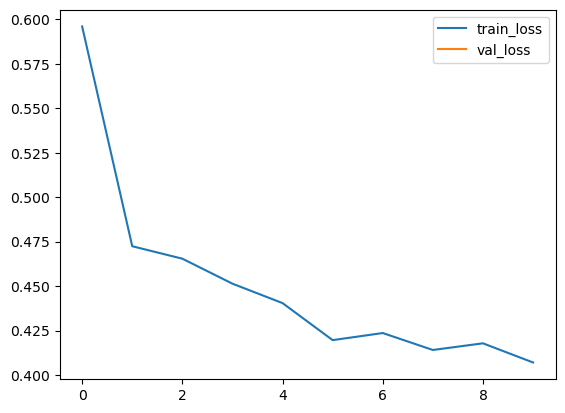

In [34]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
net = minimalMLP(out_features, in_features, num_nodes[0])

model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)
batch_size = 256
model.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks)
_ = log.plot()

surv = model.interpolate(5).predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv="km")
ev.concordance_td("antolini")

### Prediction

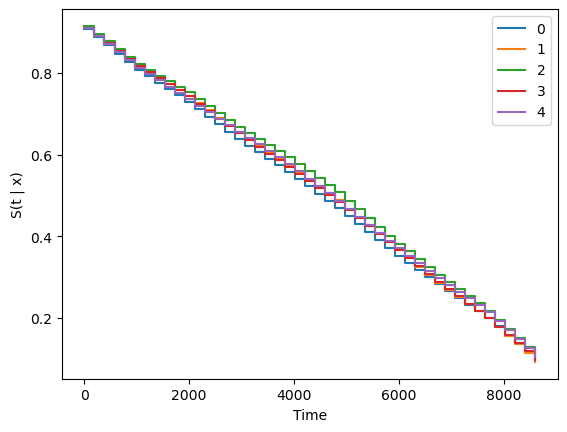

In [20]:
surv = model.interpolate(5).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle="steps-post")
plt.ylabel("S(t | x)")
_ = plt.xlabel("Time")

### Evaluation

In [22]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv="km")
ev.concordance_td("antolini")

0.5292682926829269